# Diabetes Prediction: The Exploratory Analysis
This notebook is only for the code of the exploratory analysis. For a detailed narrative, please see the report. For the predictive analytics, see the corresponding notebook.
## Module imports and notebook-wide variables

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, jaccard_score, mutual_info_score, roc_curve
from IPython import get_ipython
from IPython.display import display, Math
from IPython.display import Latex as lt
from pprint import pprint
import seaborn as sns

figure_width = 18
figure_height = 12

## Functions

In [2]:
def findBestThreshold(fprList, tprList, thresholds):
    '''
    '''
    bestDistance = 0
    for fpr, tpr, threshold in zip(fprList, tprList, thresholds):
        vec1 = [fpr, tpr] # point on ROC curve
        vec2 = [fpr, fpr] # point on diagonal line
        distance = np.sqrt(np.sum([(a - b) ** 2 for (a, b) in zip(vec1, vec2)]))
        if distance > bestDistance:
            bestDistance = distance
            bestThreshold = {'threshold': threshold,
                             'fpr': fpr,
                             'tpr': tpr}

    return bestThreshold


## Pre-processing

In [3]:
fpath = "diabetes_data_upload.csv"
# cols: Age	Gender	Polyuria	Polydipsia	sudden weight loss	weakness	Polyphagia	Genital thrush	visual blurring	Itching	Irritability	delayed healing	partial paresis	muscle stiffness	Alopecia	Obesity	class
data = pd.read_csv(fpath)

## Replace string categories to ordinal categories
pos_label = ['Yes',
             'Positive',
             'Male']
neg_label = ['No',
             'Negative',
             'Female']
data = data.replace(to_replace=pos_label + neg_label, value = [1 for _ in pos_label] + [0 for _ in neg_label])

columns = data.columns[ data.columns != 'class']
xx = data[columns].to_numpy()
yy = data['class'].to_numpy()


## Exploratory Analysis
One of the most interesting things about this project is learning about the Jaccard score. There are three ways to calculate it:
- *binary*: the score for "True" labels.
- *micro*.
- *macro*: unweighted average of each label's score.
- *weighted*: the weighted average of each label's score.
- *samples*: a multi-label calculation.
One way to read the label Jaccard score is as a rate. E.g., of all the 0s, `x`% matched on both sides. For binary classification, a 50% matching rate is equivalent to the null, that there is no association between the variables.

In [4]:
aa = [0,0,0,1,1]
bb = [0,0,1,0,1]
cc = jaccard_score(aa,bb, average=None)
print(cc)
# array([0.5       , 0.33333333])

[0.5        0.33333333]


The array `cc` can be interpreted as:
- 50% of 0s match with other 0s
- 33% of 1s match with other 1s


We can find the optimal threshold for `Age` for each other variable.

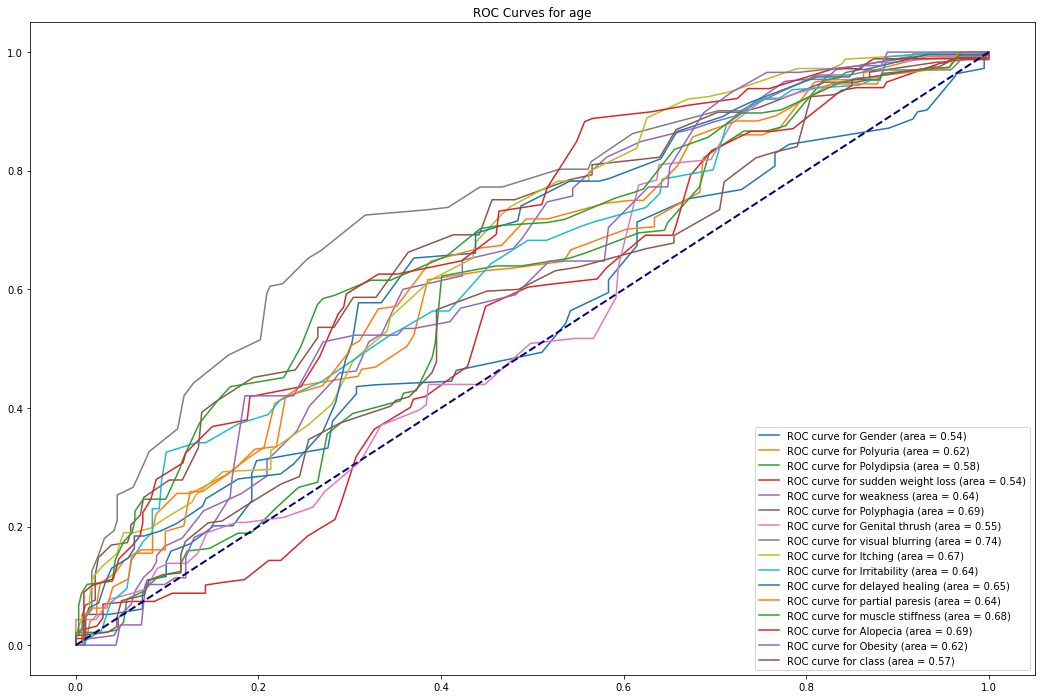

In [5]:
fig = plt.figure()
fignum = fig.number

columns = data.columns[ data.columns != 'Age' ]
age = data['Age']
ageValues = age.unique()
results = {}
for column in columns:
    fprList, tprList, thresholds = roc_curve(data[column], age)
    roc_auc = auc(fprList, tprList)
    bestThreshold = findBestThreshold(fprList, tprList, thresholds)
    results[column] = bestThreshold

    plt.plot(fprList, tprList, label=f'ROC curve for {column} (area = {roc_auc:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()
plt.title('ROC Curves for age')
fig.set_size_inches([figure_width, figure_height])
plt.show()

### Show distribution of optimal thresholds.
First we show the table which gives us the optimal threshhold with regard to each other variable. Next, we see the overall optimal threshold by calculating the median. Finally, we see the distribution with the help of a box-plot to identify potential outliers.

                    threshold       fpr       tpr
Gender                   52.0  0.307292  0.435976
Polyuria                 48.0  0.385496  0.616279
Polydipsia               48.0  0.400697  0.622318
sudden weight loss       39.0  0.696370  0.834101
weakness                 48.0  0.358140  0.600000
Polyphagia               48.0  0.363958  0.662447
Genital thrush           41.0  0.638614  0.810345
visual blurring          48.0  0.317073  0.725322
Itching                  39.0  0.625468  0.889328
Irritability             61.0  0.098985  0.325397
delayed healing          48.0  0.370107  0.652720
partial paresis          48.0  0.388514  0.647321
muscle stiffness         52.0  0.270769  0.584615
Alopecia                 42.0  0.557185  0.882682
Obesity                  55.0  0.270833  0.511364
class                    48.0  0.395000  0.565625

The median age of all the best thresholds is 48.0


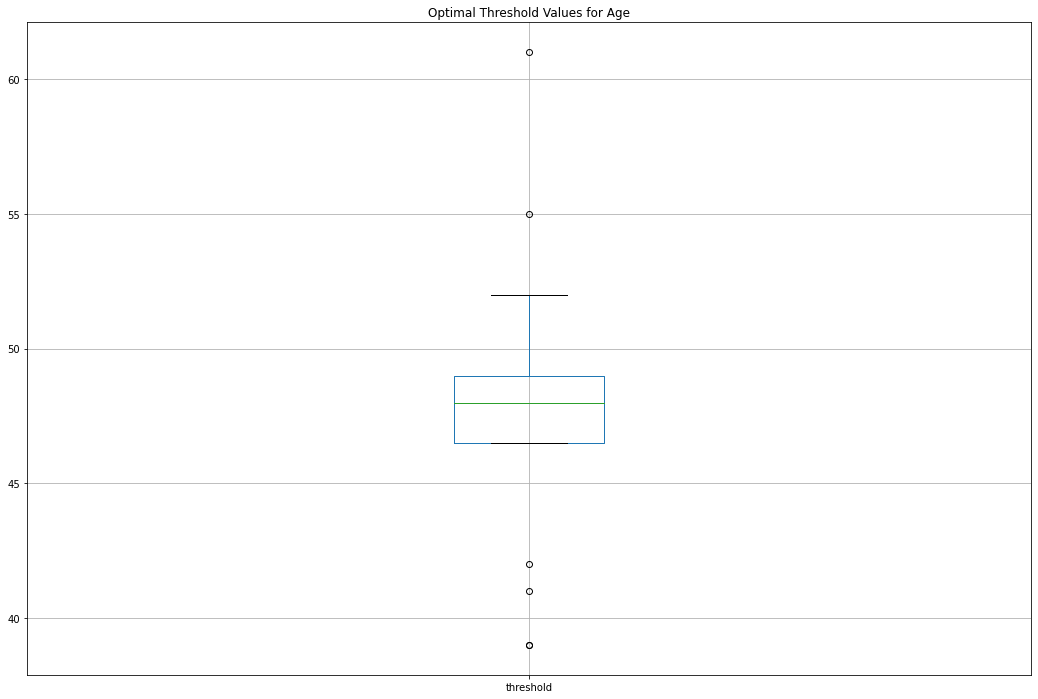

In [6]:
bestThresholds = pd.DataFrame(results).T
print(bestThresholds)
print()
print(f'The median age of all the best thresholds is {bestThresholds["threshold"].median()}')
# 48

fig = plt.figure()
fignum = fig.number
bestThresholds[['threshold']].boxplot()
plt.title('Optimal Threshold Values for Age')
fig.set_size_inches([figure_width, figure_height])
plt.show()

### Compute Jaccard score for each label
We set the similarity to `1` when comparing `Age` with itself because any variable compared to itself has a perfect association. For any variable that is compared to age, we took a focused approach and converted age to a binary variable using the optimal threshold for the pairing variable. Since we are comparing the variables head-to-head in the jaccard score, this approach is considered valid by the analyst.
In a previous attempt, we used the mutual information score, but found that it was not useful, and so settled for the jaccard score.

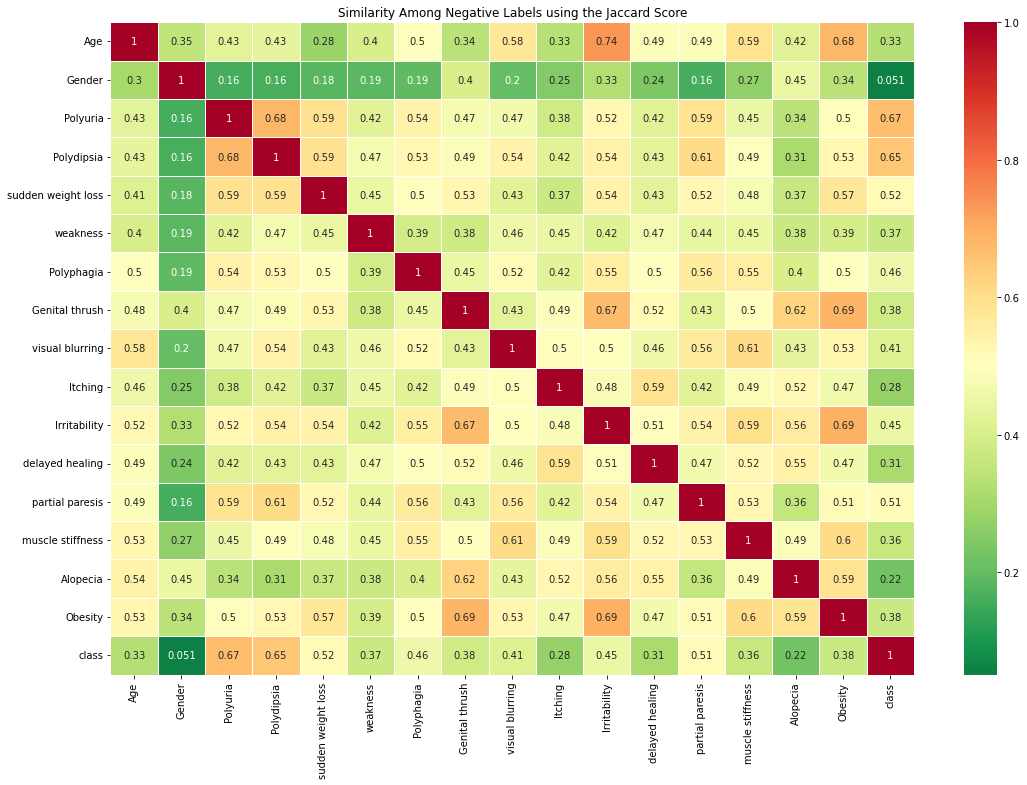

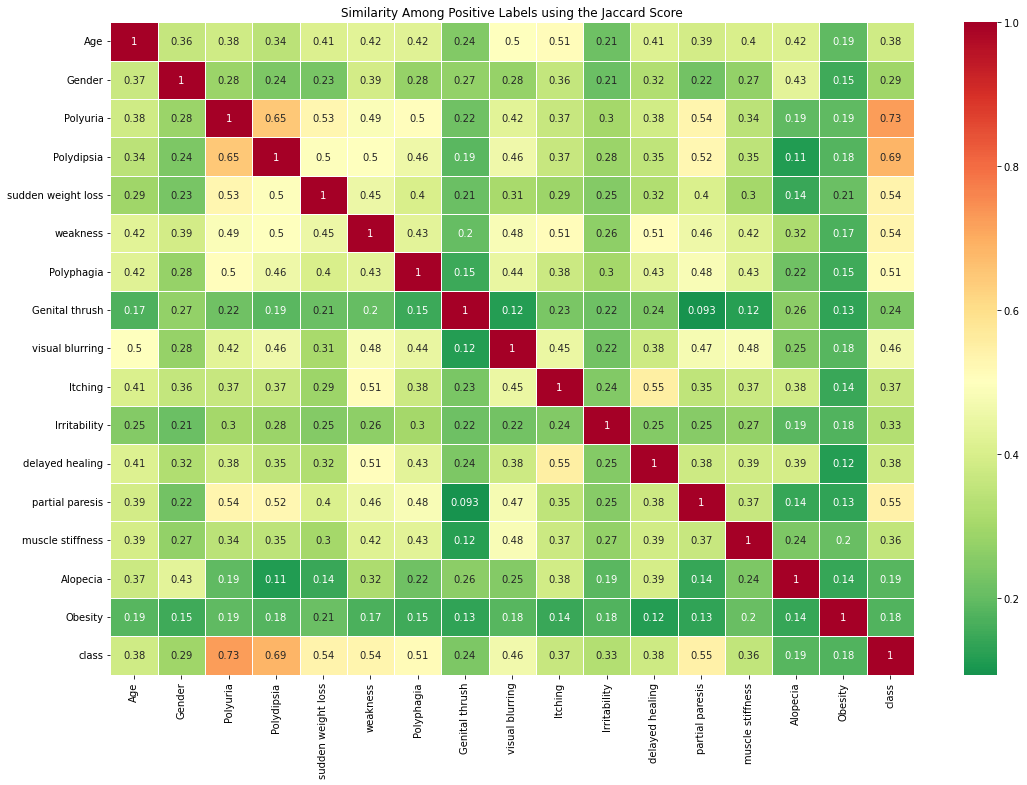

In [7]:
averageType = None
simMatrix1 = []
simMatrix2 = []
columns = data.columns
for column1 in columns:
    row1 = []
    row2 = []
    for column2 in columns:
        if column1 == 'Age' and column2 == 'Age':
            sim1 = 1
            sim2 = 1
        elif column1 == 'Age':
            # Tried using mutual information score but that was not useful.
            # sim1 = mutual_info_score(data[column1], data[column2])
            threshold = bestThresholds['threshold'][column2]
            age = (data[column1] > threshold).apply(int)
            otherVar = data[column2]
            sim1, sim2 = jaccard_score(age, otherVar, average=averageType)
        elif column2 == 'Age':
            otherVar = data[column1]
            age = (data[column2] > threshold).apply(int)
            sim1, sim2 = jaccard_score(otherVar, age, average=averageType)
        else:
            sim1, sim2 = jaccard_score(data[column1], data[column2], average=averageType)
        row1.append(sim1)
        row2.append(sim2)
    simMatrix1.append(row1)
    simMatrix2.append(row2)

simMatrix1 = pd.DataFrame(simMatrix1, columns=columns, index=columns)
simMatrix2 = pd.DataFrame(simMatrix2, columns=columns, index=columns)

fig = plt.figure()
fignum = fig.number
ax1 = sns.heatmap(simMatrix1, center=0.5, xticklabels=columns, yticklabels=columns, linewidths=0.5, cmap='RdYlGn_r', annot=True)
plt.title('Similarity Among Negative Labels using the Jaccard Score')
fig.set_size_inches([figure_width, figure_height])
plt.show()

fig = plt.figure()
fignum = fig.number
ax2 = sns.heatmap(simMatrix2, center=0.5, xticklabels=columns, yticklabels=columns, linewidths=0.5, cmap='RdYlGn_r', annot=True)
plt.title('Similarity Among Positive Labels using the Jaccard Score')
fig.set_size_inches([figure_width, figure_height])
plt.show()

Figure: Predicting negative cases. Polyuria and polydipsia have strong association with each other and class. Many other variables have moderately strong associations with each other. E.g., Lack of obesity is strongly associated with lack of genitral thrush and irritability.

Figure: Predicting positive cases. Polyuria and polydipsia have moderate positive association with each other and class. Genital thrush and obesity have moderate to strong negative association with almost all the other variables. Interesting genital thrush and partial paresis are strongly anticorrelated.

#### Compute difference between weighted mean Jaccard score and unweighted mean Jaccard score to identify imbalanced labels.


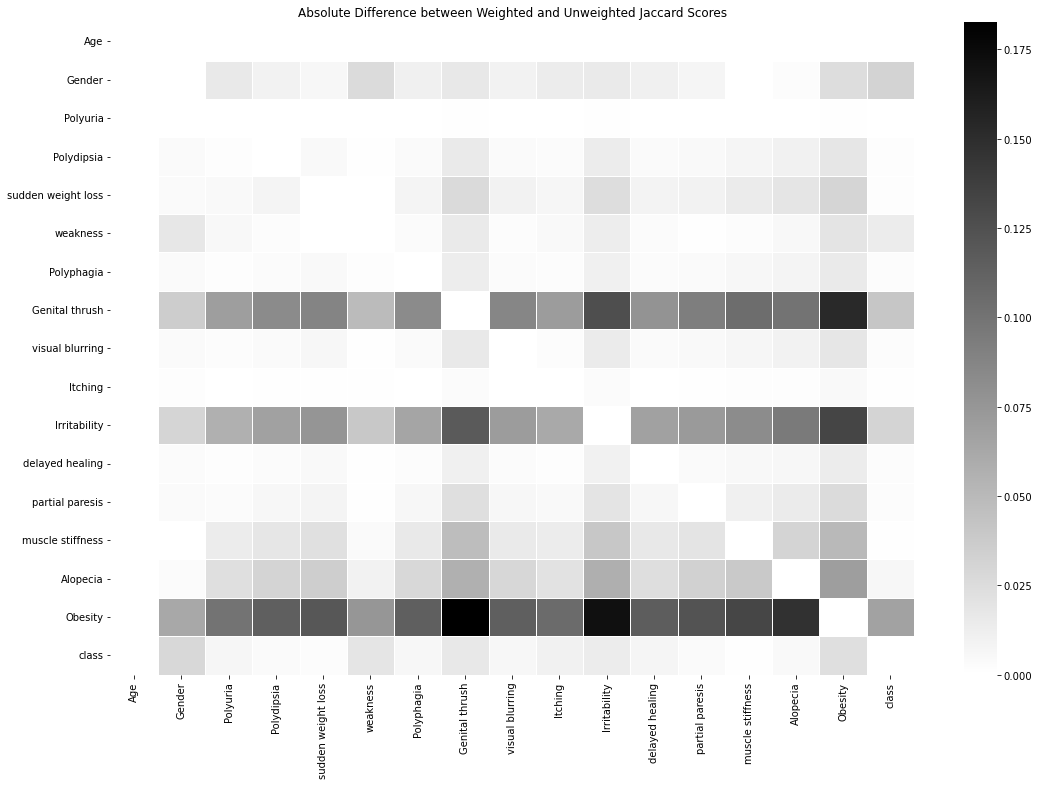

In [8]:
averageTypes = ['weighted', 'macro']
matrices = []
for averageType in averageTypes:
    simMatrix3 = []
    columns = data.columns
    for column1 in columns:
        row = []
        for column2 in columns:
            if column1 == 'Age' or column2 == 'Age':
                sim = 0
            else:
                sim = jaccard_score(data[column1], data[column2], average=averageType)
            text = f"the similarity between {column1} and {column2} is {sim:0.2f}"
            # print(text)
            row.append(sim)
        simMatrix3.append(row)
    matrices.append(simMatrix3)

difMatrix = np.abs(np.array(matrices[0]) - np.array(matrices[1]))
simMatrix3 = pd.DataFrame(simMatrix3, columns=columns, index=columns)

fig = plt.figure()
fignum = fig.number
ax3 = sns.heatmap(difMatrix, xticklabels=columns, yticklabels=columns, linewidths=0.5, cmap='binary')
plt.title('Absolute Difference between Weighted and Unweighted Jaccard Scores')
fig.set_size_inches([figure_width, figure_height])
plt.show()

Figure: Differences in weighted and unweighted jaccard scores imply label imbalances. There are notable imbalances in the labels for genital thrush, irritability, and obesity. All three of these have noticeably different weighted and unweighted means for the jaccard score.

Indeed, note the following:

In [9]:
print(np.sum(data['Obesity']==0))  # returns 432
print(np.sum(data['Obesity']==1))  # returns 88

432
88
